# EDM Classification Tutorial: Alexey Fegeding and Dmitriy Chuchuva

# Introduction
This tutorial will show you how to use data science techniques coupled with machine learning to make a simple machine to classify EDM music by genre and use that to clarify how we define what genre is as well as automatically sort new songs in to an appropriate genre. The best part about this tutorial is that it provides a basic tutorial of all the tools used so that you the user can go on and modify it as they see fit, expand on it, or transfer the knowledge to another project.

This tutorial scrapes music samples from [Beatport](https://www.beatport.com/) that fall under the following nine edm genres: trap, dubstep, hardstyle, drum and bass, electro house, progressive house, techno, trance, and big room house. These were chosen because they are some of the most popular genres in edm music. We then process the data and attempt to teach a ML algorithm to classify music given to it in to one of these genres. We want to test if a machine learning algorithm can be taught genre classification as well as show the data lifescycle in action.

This classification can also be applied to other types of genres and music. The number of songs and genres chosen will be limited by the hardware available. We chose 9 genres with 165 song samples each in the EDM genre because we both enjoy EDM music and have a server with significant computing power.

We will explore the The Data Lifecycle as outlined in [Professor John Dickerson's class taught at the University of Maryland](https://www.cs.umd.edu/class/spring2017/cmsc320/lecs/cmsc320_s2017_lec1.pdf) (slide 6)
* [Data Collection](#datacollection)
* [Data Processing](#dataprocessing)
* [Exploratory Analysis and Data Visualization](#dataviz)
* [Analysis, Hypothesis Testing, and Machine Learning](#dataml)
* [Insight and Policy Decision](#datainsight)


# Tutorial Content
This tutorial will:
* Use [beautiful soup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) to scrape data from a website (specifically, [beatport](https://www.beatport.com/)).
* Use a csv file
* Offer options to process said data
* Cconvert data in to .wav music files and process the [MFCC features](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum) of those files
* Visualize this data and make a few exploratory conclusions
* Decide on a null hypothesis
* Use machine learning to test the hypothesis
* Reject or Accept the null hypothesis
* Make a meaningful conclusion
* Explore how one can use the skills learned in this tutorial



# Libraries
You will need to install the following libraries.
* Numpy
* Beautiful Soup
* python_speech_features
* sklearn
* matplotlib

# Data Collection<a name="datacollection"></a>

We begin collecting our data by examining the beat port website. The website offers a page that lists songs of a specific genre.
![Beatport Screenshot 1](tutorial_beatport_screenshot_1.png "Beatport Screenshot 1")

This page contains an element with the maximum page number and the URL let's us speciy which page we want to load. After opening the web inspect and playing a couple samples, we can see that the songs are loaded from https://geo-samples.beatport.com/lofi/XXXXXXX.LOFI.mp3 where XXXXXXX is the song's id which is stored in the "data-ec-id" attribute of each row.

![Beatport Screenshot 2](tutorial_beatport_screenshot_2.png "Beatport Screenshot 2")
![Beatport Screenshot 3](tutorial_beatport_screenshot_3.png "Beatport Screenshot 3")

So we create a dictionary that contains a mapping where the genre is the key and the URL is value and we move forward from there.

In [1]:
import requests
import random
import math
import csv
from bs4 import BeautifulSoup


#https://www.beatport.com/genre/hip-hop-r-and-b/38/tracks?page=1&subgenre=102
#https://www.beatport.com/genre/dubstep/18/tracks?page=1
#https://www.beatport.com/genre/hard-dance/8/tracks?subgenre=100&page=1
#https://www.beatport.com/genre/drum-and-bass/1/tracks?page=1
#https://www.beatport.com/genre/electro-house/17/tracks?page=1
#https://www.beatport.com/genre/progressive-house/15/tracks?page=
#https://www.beatport.com/genre/techno/6/tracks?subgenre=126&page=1
#https://www.beatport.com/genre/trance/7/tracks?page=1

genreMap = {
    "bigroom": "https://www.beatport.com/genre/big-room/79/tracks?page=",
    "trap": "https://www.beatport.com/genre/hip-hop-r-and-b/38/tracks?subgenre=102&page=",
    "dubstep": "https://www.beatport.com/genre/dubstep/18/tracks?page=",
    "hardstyle": "https://www.beatport.com/genre/hard-dance/8/tracks?subgenre=100&page=" ,
    "drumAndBass": "https://www.beatport.com/genre/drum-and-bass/1/tracks?page=",
    "electroHouse": "https://www.beatport.com/genre/electro-house/17/tracks?page=",
    "progressiveHouse": "https://www.beatport.com/genre/progressive-house/15/tracks?page=",
    "technoElectro": "https://www.beatport.com/genre/techno/6/tracks?subgenre=126&page=",
    "trance": "https://www.beatport.com/genre/trance/7/tracks?page="
}


Because these songs are pretty large and we were constrained with disk space, we settled with using a sample size of 1485 songs. That comes out to 165 songs per genre (we have 9 genres total). We will be using 32 songs per genre for validation and the remaining 133 will be used for training.

In [ ]:
maxSamples = 1485
samplesPerGenre = math.floor(maxSamples/len(genreMap))

songStore = {}

Rather than going through each song page consecutively, we decided to choose every song randomly. Mainly because a lot of songs on Beatport are listed in order and we wanted to have some variation among artists that were chosen. So for every genre, we will pick a random page and a random track id. Then we we will save this ID to our songStore. Depending on your internet connection this part will take about 15 minutes to run.

In [ ]:
for genre, url in genreMap.items():
    songStore[genre] = []
    
    page = 1
    rawBeatportRequest = requests.get(url + str(page))
    rawBeatportHTML = rawBeatportRequest.content
    soup = BeautifulSoup(rawBeatportHTML, "lxml")
    
    maxPage = soup.find_all('a', 'pag-number')[-1].get_text()
    
    for i in range(0, samplesPerGenre):
        randomPage = random.randint(0, int(maxPage))
        rawGenrePageRequest = requests.get(url + str(randomPage))
        rawGenrePageHTML = rawGenrePageRequest.content
        
        htmlParser = BeautifulSoup(rawGenrePageHTML, "lxml")
        
        beatportTracks = htmlParser.find_all('li', 'bucket-item ec-item track')
        
        randomSongNumber = random.randint(0, len(beatportTracks) - 1)
        
        trackId = beatportTracks[randomSongNumber].get("data-ec-id")
        ##make sure we don't choose a duplicate trackId
        while trackId in songStore[genre]:
            randomPage = random.randint(0, int(maxPage))
            rawGenrePageRequest = requests.get(url + str(randomPage))
            rawGenrePageHTML = rawGenrePageRequest.content

            htmlParser = BeautifulSoup(rawGenrePageHTML, "lxml")

            beatportTracks = htmlParser.find_all('li', 'bucket-item ec-item track')

            randomSongNumber = random.randint(0, len(beatportTracks) - 1)

            trackId = beatportTracks[randomSongNumber].get("data-ec-id")
        
        songStore[genre].append(trackId)

For the sake of replication (so that we can share our dataset with you, and so that you don't have to download the track metadata every single run), we will save the track id and genre to a CSV file.

In [ ]:
with open('songs.csv', 'w') as csvfile:
    songCSVWriter = csv.writer(csvfile, delimiter=',')
    for genre, songs in songStore.items():
        for song in songs:
            songCSVWriter.writerow([genre, song])

Now that we have collected the id for every track we want download, we can download the actual tracks. This will be about 12 gigabytes of data, so this may take a while and use a lot of bandwidth depending on your internet connection :)

In [2]:
import os
from urllib.request import urlopen

baseDownloadUrl = "http://geo-samples.beatport.com/lofi/"
sampleDir = 'samples/'

with open('songs.csv', 'r') as csvfile:
    songReader = csv.reader(csvfile, delimiter=',')
    for row in songReader:
        genre = row[0]
        songId = row[1]
        #print(genre)
        #print(songId)
        songUrl = baseDownloadUrl + songId + ".LOFI.mp3"
        mp3file = urlopen(songUrl)
        songPath = sampleDir + genre + '/' + songId + '.mp3'
        
        os.makedirs(os.path.dirname(songPath), exist_ok=True)
        with open(songPath, 'wb') as output:
            output.write(mp3file.read())

# Data Processing<a name="dataprocessing"></a>

Once all the songs are downloaded, we must convert them from the MP3 format to the WAV format. In the .WAV format, we will essentially have a raw bit representation of the audio we are hearing. To convert the mp3 files into wav files, make sure you have SOX installed on Ubuntu, run (sudo apt-get install sox). We will then use the following bash script (ran from the parent directory of the samples folder):

```
for f in samples/**/*.mp3 ; do
    printf "Converting : ${f} ..."
    sox $f ${f%mp3}wav rate 44100 gain -0.1 remix -;
    printf " done!\n"
done
```

After converting everything to a WAV file, we will load up our CSV and compute the MFCC features for every song. After computing the MFCCs, we'll write them to a numpy array and save it in a .npz file, so we don't have to re-extract the features every time we want to re-train our model. We must also convert our genre to an integer representation so that we can feed it to our model. We will map integer 0...n-1 to each genre where n is the number of genres we have in total. Practical Cryptography has a very good article about the mathematics behind MFCCs and why they are powerful features to use in automatic speech recognition (see references). We will compute MFCCs using a 25 milisecond window and a 10 milisecond step size (50% overlap), these are the default parameters for python_speech_features.

In [14]:
from python_speech_features import mfcc
from python_speech_features import logfbank
import scipy.io.wavfile as wav
import numpy as np

def genreToInt(genre):
    genreList = list(genreMap)
    return genreList.index(genre)

with open('songs.csv', 'r') as csvfile:
    songReader = csv.reader(csvfile, delimiter=',')
    featuresList = []
    for row in songReader:
        genre = row[0]
        songId = row[1]
        songPath = sampleDir + genre + '/' + songId + '.wav'
        (rate,sig) = wav.read(songPath)
        mfcc_feat = mfcc(sig,rate)
        
        genreFeatures = (genreToInt(genre), mfcc_feat)
        featuresList.append(genreFeatures)
    
    features = np.array(featuresList, dtype=object)
    np.savez("features.npz", features)

print("done")

done


# Exploratory Analysis and Data Visualization<a name="dataviz"></a>
If we inspect one of the MFCCs we see that there are 12005 rows by 13 columns for every song: this equates to 12005x13 features per song. This leads usto believe that it will be difficult and slow to teach a ML algorithm to classify the EDM genres.
The null hypothesis we will attempt to reject or accept will be: A machine learning algorithm cannot be used to accurately (>=75%) classify EDM genres in to our nine chosen genres.

In [26]:
import numpy as np
import math

data_tupel_file = np.load("features.npz")
data_tupel = data_tupel_file["arr_0"]

(genre, mfcc) = data_tupel[0]
print("Track 1 MFCCs")
print(mfcc)
rows, cols = mfcc.shape
print("Rows: " + str(rows))
print("Cols: " + str(cols))

Track 1 MFCCs
[[  4.89319149 -45.98602785  -8.73327696 ...,   6.08155646  14.14889279
    7.48245302]
 [  4.78773886 -39.7851983   -2.40194405 ...,  -8.43889771   3.05990491
   11.21720388]
 [  5.12980783 -22.25192921   2.37662674 ...,   3.69266456  -6.10527061
    2.83279036]
 ..., 
 [ 19.67611435  -5.22563748   2.7053758  ...,  -2.44495684  -6.90002095
    7.23860376]
 [ 18.82508084   6.57507041   1.84635546 ...,   4.48286966 -11.70860081
   -9.46573104]
 [ 18.81307097   4.81207027  -2.84575421 ...,   0.69246709  -6.21548327
   -8.60666528]]
Rows: 12005
Cols: 13


# Analysis, Hypothesis Testing, ML<a name="dataml"></a>
We decided to implement three different machine learning algorithms: KNN, a neural network, and a support vector machine.
Below we load the data from our npz file and do some more data processing. We remove any songs that are not 2 minutes long; we remove by the number of rows in each song's MFCC matrix. We decided to do this because most songs are 2 minutes long and we lose only a little bit of data. We also split our data in to training and validation on an 80%/20% split. We then reshape the data to fit sklearn's libraries for the three ML algorithms.

In [14]:
import numpy as np
import math
from sklearn.neighbors import KNeighborsClassifier

#Load our MFCC data which is a giant np array of (genre, mfcc feature)
data_tupel_file = np.load("features.npz")
data_tupel = data_tupel_file["arr_0"]

songSamples = {}
for (genre, mfcc) in data_tupel:
    num_rows, num_cols = mfcc.shape
    try:
        if(num_rows == 12005):
            songSamples[genre].append(mfcc)
    except KeyError:
        if(num_rows == 12005):
            songSamples[genre] = [mfcc]

songValidationSamples = []
songValidationLabels = []
trainingSamples = []
trainingLabels = []
for genre, samples in songSamples.items():

    splitPoint = math.floor(0.8 * len(samples))

    songValidationSamples.extend(samples[splitPoint:])
    trainingSamples.extend(samples[:splitPoint])
    
    for i in range(0, len(samples[splitPoint:])):
        songValidationLabels.append(genre)
    for i in range(0, len(samples[:splitPoint])):
        trainingLabels.append(genre)

test_data = np.array(trainingSamples)
nsamples, nx, ny = test_data.shape
d2_train_dataset = test_data.reshape((nsamples,nx*ny))

val_data = np.array(songValidationSamples)
nval, nx, ny = val_data.shape
d2_val_dataset = val_data.reshape((nval,nx*ny))




## Neural Network
Here we implement sklearn's neural network. We scale the data using the library's standard scaler, train the neural network on our training data, and finally predict on our validation data. We output a confusion matrix which shows the predictions of the network. Unfortunately, our network only has about a 21 percent accuracy here.

In [15]:
#NNET
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report,confusion_matrix

#scale the data
scaler = StandardScaler()
# Fit only to the training data
scaler.fit(d2_train_dataset)

d2_train_dataset = scaler.transform(d2_train_dataset)
d2_val_dataset = scaler.transform(d2_val_dataset)

mlp = MLPClassifier(hidden_layer_sizes=(10))
mlp.fit(d2_train_dataset,trainingLabels)
predictions = mlp.predict(d2_val_dataset)
print(classification_report(songValidationLabels,predictions))


             precision    recall  f1-score   support

          0       0.14      0.16      0.15        32
          1       0.00      0.00      0.00        33
          2       0.20      0.10      0.13        31
          3       0.32      0.39      0.35        31
          4       0.29      0.23      0.25        31
          5       0.18      0.25      0.21        32
          6       0.10      0.06      0.08        31
          7       0.40      0.66      0.49        32
          8       0.15      0.26      0.19        31

avg / total       0.20      0.23      0.21       284



/home/nastya/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Below, we provide a more graphically appealing confusion matrix with shading to indicate how successful the machine was at guessing each genre.

Confusion matrix, without normalization


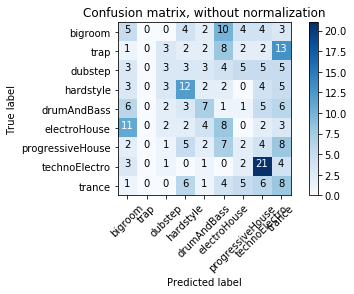

In [16]:
%matplotlib inline

import matplotlib.pyplot as plt
import itertools


# Plot Confusion Matrix Function from sklearn documentation
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cnf_matrix = confusion_matrix(songValidationLabels, predictions)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=list(genreMap),
                      title='Confusion matrix, without normalization')



## KNN: K Nearest Neighbors
Below we run sklearn's KNN algorithm using ks 10 through 15. We find that each is only about 20% accurate in classifying our validation data.

In [17]:
from sklearn.metrics import accuracy_score

for k in range(10,15):
     neigh = KNeighborsClassifier(n_neighbors=k, weights='distance') ##weights='distance'
     neigh.fit(d2_train_dataset, trainingLabels)

     predicted = neigh.predict(d2_val_dataset)
     acc = accuracy_score(songValidationLabels, predicted)
     print("K IS " + str(k) + " ACC IS " + str(acc))
print("========================")


K IS 10 ACC IS 0.211267605634
K IS 11 ACC IS 0.214788732394
K IS 12 ACC IS 0.221830985915
K IS 13 ACC IS 0.211267605634
K IS 14 ACC IS 0.221830985915


## SVM: Support Vector Machine
Here we run sklearn's SVM with the default parameters. Again, we find a low accuracy rating on our validation data, yet higher than the other machines at 34%.

In [ ]:
from sklearn import svm

clf = svm.SVC()
clf.fit(d2_train_dataset, trainingLabels)

0.345070422535
Confusion matrix, without normalization


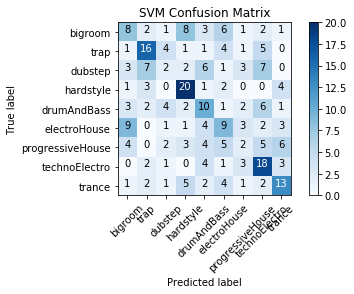

In [23]:
predicted = clf.predict(d2_val_dataset)
acc = accuracy_score(songValidationLabels, predicted)

print(acc)
cnf_matrix = confusion_matrix(songValidationLabels, predicted)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=list(genreMap),
                      title='SVM Confusion Matrix')

# Insight and Applications<a name="datainsight"></a>
We can conclude safely that we accept the null hypothesis because three of our machine learning models were not able to accurately classify the music data in to their correct EDM genre.

This may be because the MFCCs simply have too many features to be processed by a machine learning algorithm well. It may also be because the definitions of our chosen EDM genres are very vague. We found with our confusion matrix from the neural net that technoElectro classified very well while other genres were not. The SVM was also good at techno, but also hardstyle. This can indicate that technoElectro and hardstyle are better defined as genres compared to the other genres. We may also simply not have enough data. Alternatively, we found that we could not run the neural net with more than 1000 units in any one hidden layer: more computing power and more data may result in a more accurate neural net.


# Conclusion
Althogh our attempt at creating a music genre classification machine was unsuccessful, we do know that others have been successful and thus we can in the future attempt to emulate them and implement their techniques. This does not mean that our tutorial is ineffective or has no purpose. It is an example of how following the data lifecycle does not always lead to success. The tools used here can still be applied to other projects. We successfully scrape and process data, as well as successfully use sklearn's various machine learning libraries in an attempt to answer a scientific question. We learned that there may need to be a better way to represent music since MFCCs have a very large amount of features. The acceptance of our null hypothesis raises the questions of how other music genre classifiers were developed and under which data sets. We attempted to simply use free music samples where the only data provided was the sample itself and a genre. Were others using data that may already had pre-processed features? Do their machines only really work on data that looks a specific way that may be unrealistic to expect of new music coming in to market? These are the questions that are raised by the "failure" of our tutorial to make a definitive conclusion. Finally, science is one of trial and error: data scientists must be comfortable with putting sweat and tears in a project only to be able to make a conclusion that they cannot do it the way they tried. However, their attempt provides ample information, discussion, and practice of their skills.

# References

http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/

http://cs229.stanford.edu/proj2011/HaggbladeHongKao-MusicGenreClassification.pdf

https://github.com/GiantSteps/giantsteps-key-dataset